# Problem Set 2 - Naive Bayes, Decision Trees with ensemble methods
## CSCI 5622 - Fall 2021
***
**Name**: $<$Aravindakumar Vijayasri Mohan Kumar$>$ 
***

This assignment is due on Canvas by **3:55PM on October 7th**.

Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to homework 1.
***

## Overview 

Your task for this homework is to build a naive Bayes and a decision tree classifiers in the first 2 problems.
The last problem is about ensemble methods using scikit-learn decision tree as a weak learner.
We'll explore bagging, boosting (AdaBoost) and Random Forest.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from time import time
import random
%matplotlib inline

### Problem 1 - Naive Bayes [25 points]
***
Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency.
The dataset looks like the following.

|Age|Salary|Colorado Residency| College degree|
|:------:|:-----------:| :----------:|--:|
| 27 | 41,000 | Yes | Yes |
| 61 | 52,000 | No | No |
| 23 | 24,000 | Yes | No |
| 29 | 77,000 | Yes | Yes |
| 32 | 48,000 | No | Yes |
| 57 | 120,000 | Yes | Yes |
| 22 | 38,000 | Yes | Yes |
| 41 | 45,000 | Yes | No |
| 53 | 26,000 | No | No |
| 48 | 65,000 | Yes | Yes |


In [2]:
features = np.array([[27 , 41000 , 1],
              [61 , 52000 , 0],
              [23 , 24000 , 1],
              [29 , 77000 , 1],
              [32 , 48000 , 0],
              [57 , 120000 , 1],
              [22 , 38000 , 1],
              [41 , 45000 , 1],
              [53 , 26000 , 0],
              [48 , 65000 , 1]])
labels = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1])

1.1 What is our expected accuracy for the baseline case where we predict one label for all rows? (*2 points*)

# BEGIN Workspace 1.1

# Accuracy of the baseline using no features

There are 10 rows in the above sample.

Case 1: Predict 1 for all the rows

* Correctly classified 6 
* Accuracy = 6/10 = 60%

Case 2: Predict 0 for all the rows

* Correctly classified 4
* Accracy = 4/10 = 40%

# END Workspace 1.1

First, we have to find a way to deal with the continuous features. For now, let's put them into binary bins based on threshold arguments to our classifier - so we can treat this as a tuning parameter.

1.2 Complete `threshold_features` to convert age and salary features to binary ones using the threshold arguments. (*3 points*)

In [3]:
def threshold_features(features, age_threshold, salary_threshold):
    binary_X = features * 1 #This row just creates a "hard copy" of the X array so we can manipulate it as needed

    #BEGIN Workspace 1.2
    # Threshold the corresponding features
    # Column0 is Age and Column1 is Salary
    binary_X[:, 0] = np.array([0 if age < age_threshold else 1 for age in binary_X[:, 0]])
    binary_X[:, 1] = np.array([0 if salary < salary_threshold else 1 for salary in binary_X[:, 1]])
    #END Workspace 1.2

    return binary_X

As seen during the class, given a row $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,i}$.

1.3 Complete the `fit` call by computing the counts and joint counts. Hint: Use `features_counts` to store the contingency
table $N_{y,i}$ for each feature $i$ and then use them to compute $\log p(x_i | y)$ (*10 points*)

1.4 Complete the `predict` call (*5 points*)

In [4]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.features_counts = []
        self.classes_log_probabilities = None
        self.features_log_probabilities = [] # same structure as features_count

    def fit(self, X, y):
        """

        Parameters
        ----------
        X: binary np.array of shape (n_samples, n_features)
        y: corresponding labels of shape (n_samples,)
        Returns
        -------
        Trained classifier
        """

        #BEGIN Workspace 1.3

        # Compute the counts and joint counts

        # Get Classes Counts
        y_labels, y_counts = np.unique(y, return_counts=True)
        self.classes_counts = {label: count for label, count in zip(y_labels, y_counts)}

        # Get class log probabilities
        total_samples = X.shape[0]
        self.classes_log_probabilities = {label: np.log((value/total_samples)) for label, value in self.classes_counts.items()}

        # Get Frequency counts
        self.features_counts = self._get_feature_counts(X, y)

        # Get Frequency log probabilities
        self.features_log_probabilities = self._get_feature_probabilities()
        
        #END Workspace 1.3

        return self

    def predict(self, x_test):
        # joint_log_likelihood = np.zeros((x_test.shape[0], self.classes_counts.shape[0]))
        y_hat = []
        #BEGIN Workspace 1.4
        #TODO: Find the corresponding labels using Naive bayes logic

        # Get number of features
        n_features = x_test.shape[1]

        # For each x_test entry calculate which label has max value for 
        # log(Py) + Sum(feat_probability)
        for _, row in enumerate(x_test):

          prediction_dict = {}

          # Iterate through all the labels for a given data point and find
          # the max probability
          for y_label in range(2):
            y_probability = self.classes_log_probabilities[y_label]
            f_probabilities = 0

            # For each label we need to find summation of log probabilities
            for f_index, f_label in enumerate(row):
              f_probabilities += self.features_log_probabilities[f_index][y_label][f_label]
            
            # Store the probabilities for all the labels
            prediction_dict[y_label] = y_probability + f_probabilities

          # From the predicted values find the max and assign that as y_hat
          (max_label, _) = max(prediction_dict.items(), key=lambda k: k[1])

          y_hat.append(max_label)

        #END Workspace 1.4
        return y_hat


    def accuracy(self, labels, y_hat):
      """
      Construct confusion matrix and compute accuracy
      """
      c_matrix = np.zeros((2,2))

      for actual, predicted in zip(labels, y_hat):
        c_matrix[actual][predicted] += 1

      accuracy = c_matrix.diagonal().sum()/len(labels)

      return accuracy


    # Helper methods
    def _get_feature_counts(self, X, y):
      """
      Construct contingency table for each feature
      """
      # Get the number of features
      n_features = X.shape[1]

      # Keep rows as labels and columns as feature values
      frequency_tables = []
      for feature_index in range(0, n_features):
        cur_freq_table = self._get_feature_count(X, y, feature_index)
        frequency_tables.append(cur_freq_table)

      # Convert to np array
      frequency_tables = np.array(frequency_tables)
      return frequency_tables

    def _get_feature_probabilities(self):
      """
      Calculate feature probabilities from the feature counts
      """
      # Iterate and get the log probabilities
      feature_probabilities = []
      for table in self.features_counts:
        cur_probability_table = self._get_feature_probability(table)
        feature_probabilities.append(cur_probability_table)

      feature_probabilities = np.array(feature_probabilities)
      return feature_probabilities

    def _get_feature_count(self, X, labels, feature_index):
      """
      Constructs frequency table for a single feature.

      Returns:
        2D array with rows as feature values and columns as lables
      """
      # Get the unique feature values and Y labels
      u_feature_values, u_labels = self._get_unique_values(X, labels, feature_index)

      # Combine X and y for calculation purpose
      xy_array = np.hstack((X, labels.reshape(-1, 1)))
      label_index = X.shape[1]

      # Iterate over feature values and labels and form the matrix
      # Since this classifier focus on binary values value and index can be same.
      freq_table = np.zeros((len(u_feature_values), len(u_labels)))
      for l_value in u_labels:
        for f_value in u_feature_values:
          mask = (xy_array[:, feature_index]==f_value) & (xy_array[:, label_index]==l_value)
          freq_table[l_value, f_value] += len(xy_array[mask])

      return freq_table


    def _get_feature_probability(self, frequency_table):
      """
      Compute Log probability for a feature

      Returns:
        A 2D array of dim frequency_table
      """
      num_rows, num_columns = frequency_table.shape
      # Iterate and compute log probability table
      log_table = np.zeros((num_rows, num_columns))
      for row_index in range(num_rows):
        # Get N(y). Row sum will give the count
        denominator = frequency_table[row_index].sum()
        for col_index in range(num_columns):
          # Probability = N(y,i)/ N(y) 
          log_table[row_index][col_index] = self._get_log_probability(frequency_table[row_index][col_index], denominator)

      return log_table
          

    def _get_unique_values(self, X, y, feature_index):
      """
      Returns unique values in a feature and labels
      """
      # Get the unique feature values and Y labels
      u_feature_values = np.unique(X[:, feature_index])
      u_labels = np.unique(labels)
      return u_feature_values, u_labels

    def _get_log_probability(self, numerator, denominator):
      """
      Returns log probability. May or maynot apply laplace based on the alpha value
      """
      if (self.alpha == 0):
        cur_probability = numerator/denominator
        result = np.log(cur_probability)
      else:
        cur_probability = (numerator + self.alpha)/(denominator + 2*self.alpha)
        result = np.log(cur_probability)
      
      return result

1.5 Using age 30 and salary 40,000 as thresholds, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. (*5 points*)

In [5]:
clf = NaiveBayes()
#BEGIN Workspace 1.5
#TODO: Transform features to binary features, fit the classifier, report the accuracy

# Convert to binary and split the data
binary_X = threshold_features(features, 30, 40000)

# Fit the classifier
clf.fit(binary_X, labels)
# print(clf.features_log_probabilities)

# Predict
y_predict = clf.predict(binary_X)

# Get Accuracy
accuracy = clf.accuracy(labels, y_predict)
print("The accuracy of Naive Bayes is: ", accuracy)

#END Workspace 1.5

The accuracy of Naive Bayes is:  0.7


**Bonus question** 1.6 Use the attribute `alpha` of the NaiveBayes to convert it to the smoothed NaiveBayes presented during the class. (*5 points*)

In [6]:
# Smoothed Naive Bayes
clf = NaiveBayes(alpha=1.0)
#BEGIN Workspace 1.5
#TODO: Transform features to binary features, fit the classifier, report the accuracy

# Convert to binary and split the data
binary_X = threshold_features(features, 30, 40000)

# Fit the classifier
clf.fit(binary_X, labels)
# print(clf.features_log_probabilities)

# Predict
y_predict = clf.predict(binary_X)

# Get Accuracy
accuracy = clf.accuracy(labels, y_predict)
print("The accuracy of Naive Bayes is: ", accuracy)

The accuracy of Naive Bayes is:  0.7


### Problem 2 - Decision trees [25 points]
***
The goal of this problem is to implement the core elements of the Decision Tree classifier.
We do not expect a highly efficient implementation of the functions since the ensemble methods will use the implementation
from scikit-learn.

We start by considering the variable *Colorado residency*.

The leaf nodes of a decision tree act in the same way as in question (1.1) where no feature is used.

2.1 Complete `get_error_in_leaf` to return the count of misclassified instances. (*3 points*)

In [7]:
def get_error_in_leaf(y, indices):
    """
    :param y: all labels
    :param indices: the subset of indexes in the leaf node
    :return: Returns the number of errors in a leaf node of a decision tree.
    """

    error_count = 0
    #BEGIN Workspace 2.1
    # Compute the number of errors in the leaf node (no feature is used)

    filtered_labels = [y[index] for index in indices]
    label_counts = {}

    for label in range(2):
      label_counts[label] = filtered_labels.count(label)
      
    # Note: Assuming the lesser occuring label for error 
    # so that we can maximize accuracy
    error_count = min(label_counts.values())

    #END Workspace 2.1
    return error_count


def value_split_binary_feature(x, y, feature_index, root, criteria_func):
    """Will be used later to evaluate the criteria gain"""
    left_child = [i for i in root if x[i, feature_index] == 0]
    right_child = [i for i in root if x[i, feature_index] == 1]
    return criteria_func(y, root, left_child, right_child)


We will use information gain criteria to decide how to split the root node of our decision tree.

2.2 Complete the `entropy` function. (*5 points*)

2.3 Complete the `information_gain_criteria` to compute the information gained by splitting the root node.
 Print the gain value for splitting based on *Colorado residency* (*5 points*)


In [8]:
def entropy(y, indices):
    """
    :param y: all labels
    :param indices: the indices of data points
    :return: Returns the entropy in the labels for the data points in indices.
    """
    
    entropy_value = 0
    if len(indices) == 0: # deal with corner case when there is no data point.
        return entropy_value
    else:
        #BEGIN Workspace 2.2
        # Compute the entropy of the labels from indices

        filtered_labels = np.array([y[index] for index in indices])
        total_count = len(filtered_labels)
        labels, counts = np.unique(filtered_labels, return_counts=True)

        # Calculate the probability and log probability for each label
        # Probability => count/total_count
        probabilities = np.array([count/total_count for count in counts])
        log_probabilities = np.log(probabilities)

        label_probabilities = {label: probability for label, probability in zip(labels, probabilities)}
        label_log_probabilities = {label: log_probability for label, log_probability in zip(labels, log_probabilities)}

        # Calculate Entropy => Summation (-pi log2 pi) Forall i.
        for label in labels:
          cur_value = -1 * label_probabilities[label] * label_log_probabilities[label]
          entropy_value += cur_value
        
        #END Workspace 2.2
    return entropy_value

def information_gain_criteria(y, root, left_child, right_child):
    """
    :param y: all labels
    :param root: indices of all the data points in the root
    :param left_child: the subset of indices in the left child
    :param right_child: the subset of indices in the right child
    :return: information gain of the split
    """
    information_gain = 0
    #BEGIN Workspace 2.3.a
    # Compute the information gain of the split

    # Get Parent Entropy
    root_entropy = entropy(y, root)

    # Get children entropy
    left_entropy = entropy(y, left_child)
    right_entropy = entropy(y, right_child)

    # Weighted Average Entropy of children
    weighted_left = (len(left_child)/len(root)) * left_entropy
    weighted_right = (len(right_child)/len(root)) * right_entropy
    average_children_entropy = weighted_left + weighted_right

    # Info Gain = Parent Entropy - Weighted Avg child entropy
    information_gain = root_entropy - average_children_entropy
    
    #END Workspace 2.3.a
    return information_gain

In [9]:
feature_id = 2
info_gain = 0
#BEGIN Workspace 2.3.b
# report the information gain of the split based on Colorado Residency

binary_X = threshold_features(features, 30, 40000)

info_gain = value_split_binary_feature(binary_X, labels, feature_id, range(len(binary_X))   ,information_gain_criteria)
print("Information gain based on Colorado Residency: ", info_gain)

#END Workspace 2.3.b

Information gain based on Colorado Residency:  0.06326870451113265


Now we have to deal with continuous features for the decision tree.
One way to deal with continuous (or ordinal) data is to define binary features based on thresholding as we've done
for NaiveBayes. But we have to find the optimal threshold based on the criteria we're using.

2.4 Complete the `value_split_continuous_feature` by trying different possible threshold values of feature
of index `feature_index` and return the best criteria value and threshold. (*5 points*)

In [10]:
def value_split_continuous_feature(x, y, feature_index, root, criteria_func=information_gain_criteria):
    """
    :param x: all feature values
    :param y: all labels
    :param feature_index: feature id to split the tree based on
    :param root: indexes of all the data points in the root
    :param criteria_func: the splitting criteria function
    :return: Return the best value and its corresponding threshold by splitting based on a continuous feature.
    """

    best_value, best_thres = 0, 0

    #BEGIN Workspace 2.4
    # Complete the function as detailed in the question and function description

    # Iterate from min to max and then find the best threshold
    for threshold in sorted(x[:, feature_index]):

      # Convert the column to binary based on current threshold
      converted_x = x * 1
      converted_x[:, feature_index] = np.array([0 if value <= threshold else 1 for value in converted_x[:, feature_index]])

      # Call value split binary feature
      cur_info_gain = value_split_binary_feature(converted_x, y, feature_index, root, information_gain_criteria)
      if cur_info_gain > best_value: 
        best_value = cur_info_gain
        best_thres = threshold

    #END Workspace 2.4

    return best_value, best_thres

2.5 Find the best thresholds for age and salary. Print their corresponding information gains. (*5 points*)

In [11]:
root = list(range(len(labels))) # root includes all data points
#BEGIN Workspace 2.5
# Report the best thresholds for age and salary and their split information gains

age_index = 0
best_age_info_gain, best_age_threshold = value_split_continuous_feature(features, labels, age_index, root, information_gain_criteria)
print("For Age, Best Threshold:", best_age_threshold, "with Information Gain:", best_age_info_gain)

salary_index = 1
best_salary_info_gain, best_salary_threshold = value_split_continuous_feature(features, labels, salary_index, root, information_gain_criteria)
# Note: On running from min to max for salary there are multiple thresholds which get same maximum Info gain. 
# We take the first salary where it reaches Max Info Gain 
print("For Salary, Best Threshold:", best_salary_threshold, "with Information Gain:", best_salary_info_gain)

#END Workspace 2.5

For Age, Best Threshold: 57 with Information Gain: 0.10014891554392502
For Salary, Best Threshold: 26000 with Information Gain: 0.22314355131420988


2.6 Based on the obtained information gains, if we build a decision stump (decision tree with depth 1) greedily,
which feature should we choose? Why? What's the resulting accuracy? (*2 points*)

# BEGIN Workspace 2.6.a

# Which feature should we pick for the decision stump? Why?

The information gain **0.2231** is maximum for salary of **26000**. 
So we take Salary feature for creating our decision stump. We get an accuracy of **80%**

# END Workspace 2.6.a

In [12]:
#BEGIN Workspace 2.6.b
# Split based on the chosen feature and compute the accuracy (use get_error_in_leaf)

best_salary_threshold = 26000

# Take a copy of the original
salary_index = 1
feature_copy = features * 1

# Split into Left and Right child
left_indices = np.array([index for index, salary in enumerate(feature_copy[:, salary_index]) if salary <= best_salary_threshold])
right_indices = np.array([index for index, salary in enumerate(feature_copy[:, salary_index]) if salary > best_salary_threshold])

print("Left Indices:", left_indices)
print("Right Indices:", right_indices)

# Get the error count
left_error = get_error_in_leaf(labels, left_indices)
right_error = get_error_in_leaf(labels, right_indices)

print("Left Leaf Error Count:", left_error)
print("Right Leaf Error Count:", right_error)

# Accuracy 
accuracy = (len(labels) - (left_error+right_error))/len(labels)
print("Accuracy rate is:", accuracy*100, "%")

#BEGIN Workspace 2.6.b

Left Indices: [2 8]
Right Indices: [0 1 3 4 5 6 7 9]
Left Leaf Error Count: 0
Right Leaf Error Count: 2
Accuracy rate is: 80.0 %


**Bonus Question**

2.7 You now have all the ingredients to build a decision tree recursively.
You can build a decision tree of depth two and report its classification error on the training data and the tree.(*5 points*)

In [13]:
#BEGIN Workspace 2.7
# Build a Decision Tree of Depth 2 using age, salary and the previously computed thresholds

feature_labels = ["Age", "Salary", "Residency"]
feature_indices = [0, 1, 2]
max_depth = 2

def get_idx_threshold_with_max_gain(root_indices):
  """
  Returns the Feature,max threshold and info gain on which the split has to be made.
  """
  info_gains = []
  thresholds = []

  # Get the Info gain and threshold for each feature.
  for feature_index in feature_indices:
    info_gain, threshold = value_split_continuous_feature(features, labels, feature_index, root_indices, information_gain_criteria)
    info_gains.append(info_gain)
    thresholds.append(threshold)

  # Return the feature with max info gain
  max_info_gain = max(info_gains)
  idx = info_gains.index(max_info_gain)
  max_threshold = thresholds[idx]

  return idx, max_info_gain, max_threshold

  
def buildTreeRecursively(root_indices, cur_depth):
  """
  Recursively Build tree until depth of two.
  """
  # If error count is zero (or) our desired depth is reached then stop
  error_count = get_error_in_leaf(labels, root_indices)
  if error_count==0 or cur_depth==max_depth:
    print(f"Tree Level{cur_depth}:", root_indices, "Error Count:", error_count)
    return error_count
  
  # Get the feature with the most information gain for each level
  # Calculated information gain only based on available indices for that level
  feature_idx, info_gain, threshold = get_idx_threshold_with_max_gain(root_indices)

  print("------------------------------------------------------------------")
  print("Feature Idx:", feature_idx)
  print("Feature chosen:", feature_labels[feature_idx])
  print("Information Gain:", info_gain)
  print("Threshold Value:", threshold)

  # Decide the left and right nodes
  left_indices = np.array([index for index, value in enumerate(features[:, feature_idx]) if value <= threshold and index in root_indices])
  right_indices = np.array([index for index, value in enumerate(features[:, feature_idx]) if value > threshold and index in root_indices])

  # Call the recursive function
  left_count = buildTreeRecursively(left_indices, cur_depth+1)
  right_count = buildTreeRecursively(right_indices, cur_depth+1)

  return left_count + right_count

# Reporting the error count
print("Tree Levels and the indices in each level leaf nodes:")
total_error_count = buildTreeRecursively(list(range(len(labels))), 0)
print("------------------------------------------------------------------")
print("Total Error Count:", total_error_count)
tree_accuracy = (len(labels)-total_error_count)/len(labels)
print("Accuracy percentage:", tree_accuracy*100, "%")

#END Workspace 2.7

Tree Levels and the indices in each level leaf nodes:
------------------------------------------------------------------
Feature Idx: 1
Feature chosen: Salary
Information Gain: 0.22314355131420988
Threshold Value: 26000
Tree Level1: [2 8] Error Count: 0
------------------------------------------------------------------
Feature Idx: 0
Feature chosen: Age
Information Gain: 0.21576155433883565
Threshold Value: 32
Tree Level2: [0 3 4 6] Error Count: 0
Tree Level2: [1 5 7 9] Error Count: 2
------------------------------------------------------------------
Total Error Count: 2
Accuracy percentage: 80.0 %


Problem 3  - Decision Tree Ensembles: Bagging and Boosting [50 points]
---

We are going to predict house price levels using decision tree ensembles.

In this classification problem, we compare Decision trees and it's ensembles - Bagging and Boosting on House Price prediction [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Our *weak learner* for this problem is the DecisionTreeClassifier from scikit-learn with `max_depth=10`.

We start first by loading preprocessed data that we'll use. Since the original data is for regression, we have first to transform
`y_train` and `y_test` to discrete values reflecting price level.

|Price range| Label|
|:----------:|--:|
| $ P < $125000|0|
|125000$\leq P < $ 160000| 1 |
|160000$ \leq P < $ 200000| 2 |
|200000$ \leq P $ | 3 |

3.1 Start by transforming`y_train` and `y_test` to discrete values using the provided ranges. (*3 points*)

In [14]:
def discretize_y(y_value):
  """
  Discretize Y values based on the given range
  """
  if y_value < 125000: 
    return 0
  elif y_value < 160000:
    return 1
  elif y_value < 200000:
    return 2
  else:
    return 3 

In [15]:
X_train, X_test, y_train, y_test = pickle.load(open('data/test_train.pkl','rb'))
#BEGIN Workspace 3.1
# Discretize y_train and y_test

y_train = np.array([discretize_y(value) for value in y_train])
y_test = np.array([discretize_y(value) for value in y_test])

#END Workspace 3.1
print(np.unique(y_train), X_train.shape)
print(np.unique(y_test), X_test.shape)

[0 1 2 3] (1166, 79)
[0 1 2 3] (292, 79)


3.2 Complete the `ensemble_test` class to `fit` the model received as parameter and store the metrics and running time. (*5 points*)

3.3 Complete `plot_metric` to show and compare different statistics of each model in a bar chart. (*5 points*)

Later we will also use `ensemble_test` class to plot score, metric and time taken to fit the data.

In [16]:
def get_weak_learner():
    """Return a new instance of out chosen weak learner"""
    return DecisionTreeClassifier(max_depth=10)

class EnsembleTest:
    """
        Test multiple model performance
    """

    def __init__(self, x_train, y_train, x_test, y_test):
        """
        initialize data partitions
        """
        self.scores = {}
        self.execution_time = {}
        self.metric = {}
        self.x_train = X_train
        self.y_train = y_train
        self.x_test = X_test
        self.y_test = y_test
        # Note: Label String was interchanged in given question. I have altered it.
        self.score_name ='Precision(micro)' 
        self.metric_name = 'Mean Accuracy'

    def fit_model(self, model, name):
        """
        Fit the model on train data.
        predict on test and store score and execution time for each fit.
        :param model: model
        :param name: name of model
        """
        start = time()
        # BEGIN Workspace 3.2
        # Fit the model and get the predictions
        # train and test data are treated as global variables
        model.fit(self.x_train, self.y_train)

        y_hat = model.predict(self.x_test)
        c_matrix = self.confusion_matrix(y_hat)

        #Hint: self.scores[name] = precision_score(?, average="micro") # in multi-class, micro implies treating it as binary precision
        #Hint self.metric[name] = Accuracy
        self.scores[name] = self.precision_score(c_matrix)
        self.metric[name] = (c_matrix.diagonal().sum())/len(self.y_test)

        #END Workspace 3.2
        self.execution_time[name] = time() - start

    def print_result(self):
        """
            print results for all models trained and tested.
        """
        models_cross = pd.DataFrame({
            'Model'              : list(self.metric.keys()),
             self.score_name     : list(self.scores.values()),
             self.metric_name    : list(self.metric.values()),
            'Execution time'     : list(self.execution_time.values())})
        print(models_cross.sort_values(by=self.score_name, ascending=False))

    def plot_metric(self):
        #BEGIN Workspace 3.3
        # Plot bar chart for each metric : time, metric, score

        # String Constants
        model = "Models"
        time = "Execution Time"
        score = "Precision Score"
        accuracy = "Accuracy"

        x_values = self.metric.keys()

        plt.title("Model comparisons")
        # Precision plot
        self._plot_metric(x_values, self.scores.values(), model, score, "orange")
        # Accuracy Plot
        self._plot_metric(x_values, self.metric.values(), model, accuracy, "blue")
        # Time taken plot
        self._plot_metric(x_values, self.execution_time.values(), model, time, "green")
        #END Workspace 3.3


    # Helpers
    def confusion_matrix(self, y_hat):
      """
      Generates confusion matrix

      Params:
        y_hat: Predicted labels for y.
      """
      # initialize c_matrix
      c_matrix = np.zeros((4,4))

      # Labels are from 0 to 3
      for actual, predicted in zip(self.y_test, y_hat):
        c_matrix[actual][predicted] += 1

      return c_matrix

    def precision_score(self, c_matrix, average="micro"):
      """
      Calculate the precision score based on the averaging scheme passed.

      Params: 
        c_matrix: Confusion matrix 
        average: string that accepts "micro" or "macro"
      """
      # Initialize String constants used
      tp_label = "tp"
      fp_label = "fp"

      # For precision = TP / (TP + FP)
      # So we calculate TP and FP for each label
      positives_dict = self._compute_positives(c_matrix, tp_label, fp_label)
      
      # Now based on micro (or) macro average scheme we compute the precision
      precision_score = None
      if average == "micro":
        precision_score = self._compute_micro_precision(positives_dict, tp_label, fp_label)
      else:
        precision_score = self._compute_macro_precision(positives_dict, tp_label, fp_label)

      return precision_score

    def _compute_positives(self, c_matrix, tp_label, fp_label):
      """
      Compute TP and FP for each class and returns a dictionary

      Params:
        c_matrix: Confusion matrix
        tp_label: Label for TP
        fp_label: Label for FP
      """
      # Initialize a dummy dictionary
      positives_dict = {}

      # For each predicted label iterate all the actual labels and compute
      for predicted in range(4):
        # Initialize both counts as Zero
        tp_count, fp_count = 0,0
        for actual in range(4):
          if predicted == actual: # TP
            tp_count += c_matrix[actual][predicted]
          else: # FP
            fp_count += c_matrix[actual][predicted]
        cur_counts = {tp_label: tp_count, fp_label: fp_count}
        positives_dict[predicted] = cur_counts
      
      return positives_dict

    def _compute_micro_precision(self, positives_dict, tp_label, fp_label):
      """
      Compute Micro precision.

      Params:
        positives_dict: A dict which contains tp and fp values for each class
        tp_label: Label for TP
        fp_label: Label for FP
      """
      # Micro average precision = (total TP) / (total TP + total FP)
      total_tp = sum([value[tp_label] for value in positives_dict.values()])
      total_fp = sum([value[fp_label] for value in positives_dict.values()])

      # Compute micro average
      micro_average = total_tp/ (total_tp + total_fp)
      return micro_average


    def _compute_macro_precision(self, positives_dict, tp_label, fp_label):
      """
      Compute Macro precision.

      Params:
        positives_dict: A dict which contains tp and fp values for each class
        tp_label: Label for TP
        fp_label: Label for FP
      """
      # Calculates precision for each class individually
      compute_precision = lambda v: (v[tp_label]) / (v[tp_label] + v[fp_label])

      # Macro average precision = Avg(macro_precision), for all labels
      macro_precisions = {label: compute_precision(value) for label, value in positives_dict.items()}

      # Compute macro average
      macro_average = sum(macro_precisions.values()) / len(macro_precisions)
      return macro_average

    def _plot_metric(self, x_values, y_values, xlabel, ylabel, color):
      """
      Plot a bar chart for the given metrics

      """
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
      plt.bar(x_values, y_values, color=color)
      plt.figure(figsize=(8, 6), dpi=80)
      plt.show()


3.4 Test `EnsembleTest` using our weak learner returned by `get_weak_learner` (*2 points*)

    Model  Precision(micro)  Mean Accuracy  Execution time
2  Model3          0.691781       0.691781        0.012646
0  Model1          0.671233       0.671233        0.014414
1  Model2          0.657534       0.657534        0.012804


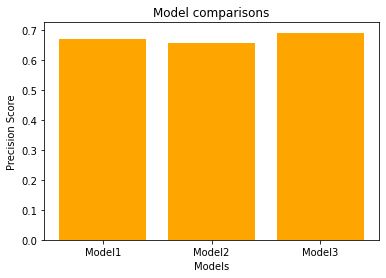

<Figure size 640x480 with 0 Axes>

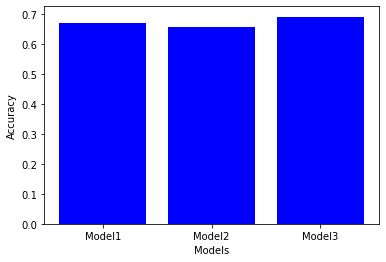

<Figure size 640x480 with 0 Axes>

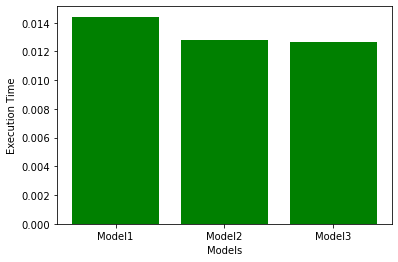

<Figure size 640x480 with 0 Axes>

In [17]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(X_train,y_train,X_test,y_test)
#BEGIN Workspace 3.4
# Initialize weak learner and fit ensemble_handler

for model_number in range(1,4):
  model = get_weak_learner()
  ensemble_handler.fit_model(model, f"Model{model_number}")

#END Workspace 3.4
ensemble_handler.print_result()

# Plot metrics
ensemble_handler.plot_metric()

**Bagging:**

Bagging consists of training a set of weak learners using random subsets of the train data.

3.5 First, complete `sample_data` to return a random sample of size `sample_ratio * len(X_train)` of features and labels (*2 points*)

3.6 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random sample of the data (*5 points*)

3.7 Complete `predict` method to return the most likely label by combining different estimators predictions. 
Use a simple majority / plurality vote system similar to the one used in your KNNClassifier in Problem Set 1. However, in this case, to break a tie you should use `predict_log_proba` or `predict_proba` method of DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba) (*2 points*)

In [18]:
class BaggingEnsemble(object):

    def __init__(self, n_estimators, sample_ratio):
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.estimators = []

    def sample_data(self, x_train, y_train):
        x_sample, y_sample = None, None
        #BEGIN Workspace 3.5
        # sample random subset of size sample_ratio * len(X_train)

        sample_size = int(self.sample_ratio * len(x_train))
        x_sample, y_sample = self.get_sampled_data(x_train, y_train, sample_size)

        #END Workspace 3.5
        return x_sample, y_sample

    def fit(self, x_train, y_train):
        for _ in range(self.n_estimators):
            #BEGIN Workspace 3.6
            # sample data and create new weak learned trained on the sample

            x_sample, y_sample = self.sample_data(x_train, y_train)
            model = get_weak_learner()
            model.fit(x_sample, y_sample)
            self.estimators.append(model)

            #END Workspace 3.6

    def predict(self, X_test):
        answer = None
        #BEGIN Workspace 3.7
        # go through the trained estimators and acummulate their predicted_proba to get the mostly likely label
        answer = self.get_predicted_labels(X_test)
        #END Workspace 3.7
        return answer

    # Helpers
    def get_sampled_data(self, x_train, y_train, sample_size):
      """
      Constructs random sampling of data based on sample size

      Params:
        x_train: Original training data
        y_train: Original labels
        sample_size: Target length obtained based on sample ratio.
      """
      # Get the indices that needs to be filtered out
      row_indices = random.sample(range(len(x_train)), sample_size)
      
      # Filter out the rows selected above from the sample
      x_result = np.take(x_train, row_indices, axis=0)
      y_result = np.take(y_train, row_indices)

      return x_result, y_result

    def get_predicted_labels(self, X_test):
      """
      Predicts the Output label based on highest predicted probability

      Params:
        X_test: Test data set (n_samples, n_features)

      Returns:
        y_hat: Predicted labels of dimension (n_samples, )
      """
      # Initialize Cumulative Probability array
      estimator_probs = []

      # Iterate through each estimator and find the predicted probs 
      # and add it to cumulative probability
      for estimator in self.estimators:
        # Predicted Proba shape => (n_samples, # of class labels) 
        # Class labels 4 in this case
        predicted_probs = estimator.predict_proba(X_test)
        # Add to estimator_probs
        estimator_probs.append(predicted_probs)

      # Add all the predicted probs
      cumulative_probs = sum(estimator_probs)
      
      # Get label for maximum probability for each data point and return
      y_hat = np.argmax(cumulative_probs, axis=1)

      return y_hat


In [19]:
# This cell should run without errors
ensemble_handler.fit_model(BaggingEnsemble(10, 0.9),'Bagging')
ensemble_handler.print_result()

     Model  Precision(micro)  Mean Accuracy  Execution time
3  Bagging          0.729452       0.729452        0.116617
2   Model3          0.691781       0.691781        0.012646
0   Model1          0.671233       0.671233        0.014414
1   Model2          0.657534       0.657534        0.012804


**Random Forest**
Random Forest has an additional layer of randomness compared to Bagging: we also sample a random subset of the features.

3.8 First, complete `sample_data` to return a random sample of size `sample_ratio * len(X_train)` of labels and `feature_ratio * num_features` of features (*2 points*)

3.9 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random sample of the data.
Make sure to keep track of the sampled features for each estimator to use them in the prediction step. (*5 points*)

3.10 Complete `predict` method to return the most likely label by combining different estimators predictions.
Use a simple majority / plurality vote system similar to the one used in your KNNClassifier in Problem Set 1. However, in this case, to break a tie you should use `predict_log_proba` or `predict_proba`  method of DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba) (*3 points*)


In [20]:
class RandomForest(object):

    def __init__(self, n_estimators, sample_ratio, features_ratio):
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.features_ratio = features_ratio
        self.estimators = []
        self.features_indices = []

    def sample_data(self, x_train, y_train):
        X_sample, y_sample, features_indices = None, None, None
        #BEGIN Workspace 3.8
        # sample random subset of size sample_ratio * len(X_train) and subset of features of size
        # features_ratio * num_features

        # Row sampling
        row_size = int(self.sample_ratio * len(x_train))
        x_sample, y_sample = self.get_row_sampling(x_train, y_train, row_size)

        # Feature sampling
        col_size = int(self.features_ratio * x_train.shape[1])
        x_sample, features_indices = self.get_feature_sampling(x_sample, col_size)

        #END Workspace 3.8
        return x_sample, y_sample, features_indices

    def fit(self, x_train, y_train):
        for _ in range(self.n_estimators):
            #BEGIN Workspace 3.9
            # sample data with random subset of rows and features using sample_data
            # keep track of the features indices in features_indices to use in predict

            x_sample, y_sample, cur_feature_indices = self.sample_data(x_train, y_train)
            model = get_weak_learner()
            model.fit(x_sample, y_sample)
            self.estimators.append(model)
            self.features_indices.append(cur_feature_indices)

            #END Workspace 3.9

    def predict(self, X_test):
        predicted_proba = 0
        answer = 0
        #BEGIN Workspace 3.10
        # compute cumulative sum of predict proba from estimators and return the labels with highest likelihood
        answer = self.get_predicted_labels(X_test)
        #END Workspace 3.10
        return answer

    # Helpers
    def get_row_sampling(self, x_train, y_train, sample_size):
      """
      Constructs random sampling of data based on sample size

      Params:
        x_train: Original training data
        y_train: Original labels
        sample_size: Target length obtained based on sample ratio.
      """
      # Get the indices that needs to be filtered out
      row_indices = random.sample(range(len(x_train)), sample_size)
      
      # Filter out the rows selected above from the sample
      x_result = np.take(x_train, row_indices, axis=0)
      y_result = np.take(y_train, row_indices)

      return x_result, y_result

    def get_feature_sampling(self, x_train, sample_size):
      """
      Sample random features and return

      Params:
        x_train: Row sampled training data
        sample_size: Number of features/columns to select
      """
      # Get random feature indices
      feature_indices = random.sample(range(x_train.shape[1]), sample_size)

      # Filter out the indices from X_train (column filter)
      filtered_x_train = np.take(x_train, feature_indices, axis=1)

      return filtered_x_train, feature_indices


    def get_predicted_labels(self, X_test):
      """
      Predicts the Output label based on highest predicted probability

      Params:
        X_test: Test data set (n_samples, n_features)

      Returns:
        y_hat: Predicted labels of dimension (n_samples, )
      """
      # Initialize estimator results
      estimator_probs = []
      
      # Iterate through each estimator and find the predicted probs 
      # and add it to cumulative probability
      for estimator, feature_indices in zip(self.estimators, self.features_indices):

        # Get only the features for this estimator
        x_test_filtered = np.take(X_test, feature_indices, axis=1)

        # Predicted Proba shape => (n_samples, # of class labels) 
        # Class labels 4 in this case
        predicted_probs = estimator.predict_proba(x_test_filtered)

        # Add to estimator probs
        estimator_probs.append(predicted_probs)

      # Take sum of all the elements in the results
      cumulative_probs = sum(estimator_probs)
        
      # Get label for maximum probability for each data point and return
      y_hat = np.argmax(cumulative_probs, axis=1)

      return y_hat

In [21]:
# This cell should run without errors
ensemble_handler.fit_model(RandomForest(20, sample_ratio=0.9, features_ratio=0.8), 'RandomForest')
ensemble_handler.print_result()

          Model  Precision(micro)  Mean Accuracy  Execution time
4  RandomForest          0.780822       0.780822        0.197983
3       Bagging          0.729452       0.729452        0.116617
2        Model3          0.691781       0.691781        0.012646
0        Model1          0.671233       0.671233        0.014414
1        Model2          0.657534       0.657534        0.012804


**Boosting**

There are different methods of boosting, but we'll focus in this problem on Adaptive Boosting (AdaBoost).
The logic of AdaBoost is to "push" the new learner to give more importance to previously misclassified data. We present
below the multiclass variant of AdaBoost [SAMME](https://web.stanford.edu/~hastie/Papers/samme.pdf). We denote $K$ the number of classes.

AdaBosst is performed by increasing the weights of misclassified simple after each iteration:
- Start with equal weights $W_1 = (w_i), $ where   $w_i = \frac{1}{\texttt{n_samples}}$
- at step j:
    - Train estimator $h_j$ using weights $W_j$
    - Find the weighted error rate $\epsilon_j$ using $W_j$: $\epsilon_j=\frac{\sum_i w_i \delta(\hat{y}_i, y_i)}{\sum_i w_i}$
    - Choose $\alpha_j = \log \frac{1-\epsilon_j}{\epsilon_j} + \log(K-1)$
    - Update $W_j$ using: $w_i \leftarrow w_i \exp(\alpha_j \delta(\hat{y_i}, y_i)) $
    - Normalize $W_j$ to have sum 1
- Global estimator is $H = \sum_j \alpha_j h_j$

$\hat{y}$ are the predicted labels, and $\delta$ the Kronecker function, equal to 1 when the two argument are equal, 0 otherwise.


3.11 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on the same data but with different
samples weights as detailed in the algorithm. Keep track of $(\alpha_i)$ (*7 points*)

3.12 Complete `predict` method to return the predicted label using the global estimator $H$ (*5 points*). Hint:
use one hot encoding of the predicted labels from the weak learners and cumulate the prediction with weights $\alpha_j$ 

Notice that if the weak learner is consistent (0 error rate on the training set), AdaBoost $\alpha_j$ are no longer defined.

In [22]:
class AdaBoost(object):

    def __init__(self, n_estimators, num_classes=4):
        self.n_estimators = n_estimators
        self.num_classes = num_classes
        self.estimators = []
        self.alphas = []
        self.weights = None


    def fit(self, X_train, y_train):
        #BEGIN Workspace 3.11
        # Implement Multiclass Adaboost and keep track of the alpha_j

        # Get the initial weights
        n_samples = len(X_train)
        self.weights = np.array([1/n_samples] * n_samples)

        for _ in range(self.n_estimators):

          # Initialize model and train the data
          model = get_weak_learner()
          model.fit(X_train, y_train, sample_weight=self.weights)

          # Predict the y_hat for the train data
          y_hat_train = model.predict(X_train)

          # Get Kronecker function for the predicted and actual: Delta(y_hat, y)
          kronecker_values = [np.not_equal(actual, predicted).astype(int) for actual, predicted in zip(y_train, y_hat_train)]

          # Weighted error calculation
          error_j, alpha_j = self.get_weighted_error_and_alpha(kronecker_values)
          if error_j == 0:
            break

          # Store Alpha_j and estimator
          self.estimators.append(model)
          self.alphas.append(alpha_j)

          # Update Weights for next iteration
          self.update_weights(alpha_j, kronecker_values)

        #END Workspace 3.11

    def predict(self, X_test):
        answer = 0
        #BEGIN Workspace 3.12
        # get the labels returned by the global estimator defined as H
        # Use one-hot format to get the labels using the global estimator
        # We don't need predict_proba for this one
        answer = self.get_predicted_labels(X_test)
        #END Workspace 3.12
        return answer

    # Helpers
    def update_weights(self, alpha_j, kronecker_values):
      """
      Update weights for the next cycle using the formula provided

      Params:
        alpha_j: Current Alpha value
        kronecker_values: Delta(y_hat, y)
      """
      # Get the exponential values
      alpha_exp = [alpha_j if kvalue else 0 for kvalue in kronecker_values] 
      exp_values = np.exp(alpha_exp)

      # Update the weights
      weights = [weight*expo for weight, expo in zip(self.weights, exp_values)]

      # Normalize the weights
      weight_sum = sum(weights)
      self.weights = np.array([weight/weight_sum for weight in weights])

      return

    def get_weighted_error_and_alpha(self, kronecker_values):
      """
      Calculate the weighted error and Alpha based on the formula given

      Params:
        kronecker_values: Delta(y_hat, y)
      """
      # Get weighted error
      numerator = sum([weight for weight, kvalue in zip(self.weights, kronecker_values) if kvalue])
      denominator = sum(self.weights)
      error = numerator/denominator

      # Calculate Alpha
      # Alpha is defined only when Error not equal zero
      if error==0:
        alpha = None 
      else:
        first_entry = (1-error)/error
        alpha = sum(np.log([first_entry, self.num_classes-1]))

      return error, alpha

    def get_predicted_labels(self, X_test):
      """
      Get the predicted labels using the methodology given

      Params:
        X_test: Test data set
      """
      # Estimators results
      estimators_results = []
      
      # Iterate over the estimators and get one hot encoded values
      for estimator, alpha in zip(self.estimators, self.alphas):

        # If Alpha is None then we don't calculate
        if alpha is None: 
          break

        # Predict the test data
        y_hat = estimator.predict(X_test)

        # Get one hot encoding
        encoded_y_hat = self.get_encoded_y_hat(y_hat)

        # Multiply with Alpha
        cur_result = encoded_y_hat * alpha

        # Add to estimator results
        estimators_results.append(cur_result)

      # Take the sum
      cumulative_sums = sum(estimators_results)
      
      # Get the max value (Since every value is negative we take argmin)
      y_hat = np.argmax(cumulative_sums, axis=1) 
  
      return y_hat


    def get_encoded_y_hat(self, y_hat):
      """
      Get encoded y_hat values
      """
      # Initialize empty array
      one_hot_encoded = np.zeros((len(y_hat), 4))

      # Encode the y_hat values
      for idx, predicted in enumerate(y_hat):
        one_hot_encoded[idx][predicted] = 1

      return one_hot_encoded


In [23]:
# This cell should run without errors
ensemble_handler.fit_model(AdaBoost(10), 'AdaBoost')
ensemble_handler.print_result()

          Model  Precision(micro)  Mean Accuracy  Execution time
4  RandomForest          0.780822       0.780822        0.197983
5      AdaBoost          0.732877       0.732877        0.164353
3       Bagging          0.729452       0.729452        0.116617
2        Model3          0.691781       0.691781        0.012646
0        Model1          0.671233       0.671233        0.014414
1        Model2          0.657534       0.657534        0.012804


**Comparison**

3.13 Add different ensemble methods to the handler (try different parameters), plot, show, and compare them (*5 points*).

   Model  Precision(micro)  Mean Accuracy  Execution time
8  RF_15          0.777397       0.777397        0.148569
2   RF_5          0.763699       0.763699        0.049938
5  RF_10          0.750000       0.750000        0.097426
9  AB_15          0.743151       0.743151        0.243797
6  AB_10          0.739726       0.739726        0.162039
4   B_10          0.736301       0.736301        0.112622
7   B_15          0.736301       0.736301        0.171084
1    B_5          0.719178       0.719178        0.057027
3   AB_5          0.715753       0.715753        0.082001
0     DT          0.671233       0.671233        0.012617


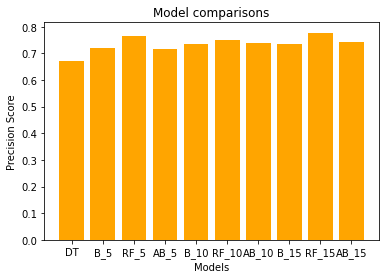

<Figure size 640x480 with 0 Axes>

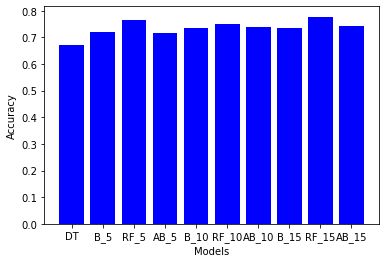

<Figure size 640x480 with 0 Axes>

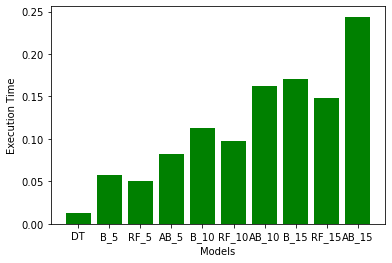

<Figure size 640x480 with 0 Axes>

   Model  Precision(micro)  Mean Accuracy  Execution time
1   B_70          0.770548       0.770548        0.088626
2  RF_70          0.767123       0.767123        0.074200
6  RF_90          0.753425       0.753425        0.100221
3   B_80          0.743151       0.743151        0.099220
4  RF_80          0.743151       0.743151        0.086674
5   B_90          0.736301       0.736301        0.113069
0     DT          0.660959       0.660959        0.013446


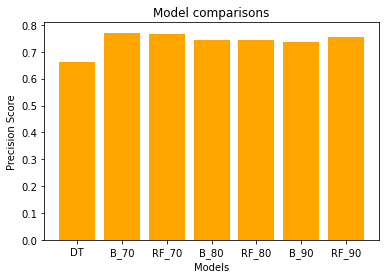

<Figure size 640x480 with 0 Axes>

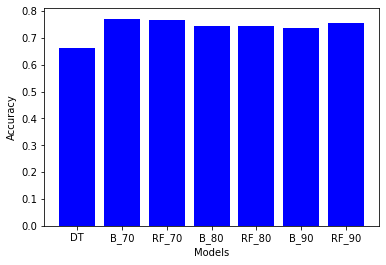

<Figure size 640x480 with 0 Axes>

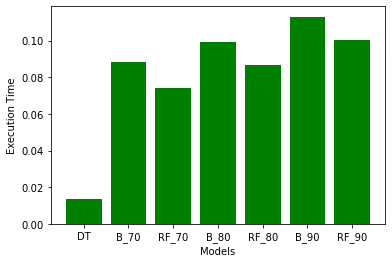

<Figure size 640x480 with 0 Axes>

   Model  Precision(micro)  Mean Accuracy  Execution time
1  RF_70          0.763699       0.763699        0.089079
2  RF_80          0.756849       0.756849        0.098319
3  RF_90          0.726027       0.726027        0.105685
0     DT          0.688356       0.688356        0.013181


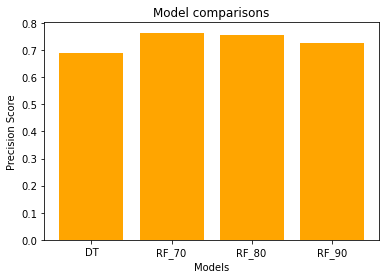

<Figure size 640x480 with 0 Axes>

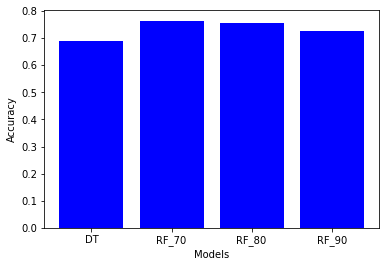

<Figure size 640x480 with 0 Axes>

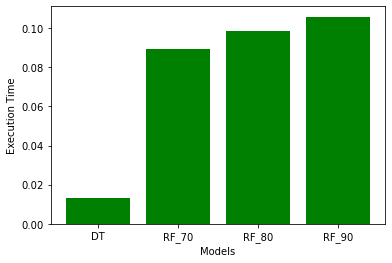

<Figure size 640x480 with 0 Axes>

In [24]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(X_train, y_train, X_test, y_test)
decision = get_weak_learner()
ensemble_handler.fit_model(decision,'decision_tree')

#BEGIN Workspace 3.13.a
# Add multiple instances of the ensemble methods. Plot and compare their performance

# Get an instance of Ensemble handler
def get_ensemble_handler():
  """
  Returns an ensemble handler with Single decision tree
  """
  ensemble_handler = EnsembleTest(X_train, y_train, X_test, y_test)
  decision = get_weak_learner()
  ensemble_handler.fit_model(decision,'DT')
  return ensemble_handler

# Plot metrics for different Estimator size
def compare_estimator_size(estimator_sizes, row_ratio=0.9, feature_ratio=0.8):
  """
  Compare models across different estimator sizes
  """
  # Get a new instance of ensemble handler
  ensemble_handler = get_ensemble_handler()

  # Fit different models
  for size in estimator_sizes:
    ensemble_handler.fit_model(BaggingEnsemble(size, row_ratio), f"B_{size}")
    ensemble_handler.fit_model(RandomForest(size, row_ratio, feature_ratio), f"RF_{size}")
    ensemble_handler.fit_model(AdaBoost(size), f"AB_{size}")
  
  # Print the result
  ensemble_handler.print_result()

  # Plot the metrics
  ensemble_handler.plot_metric()
  return 

# Plot metrics for Row Ratio variations
def compare_sample_ratios(row_ratios, feature_ratio=0.8, size=10):
  """
  Compare models across different sample ratios
  """
  # Get a new instance of ensemble handler
  ensemble_handler = get_ensemble_handler()

  # Fit different models
  # Plot only for Bagging and Random forests. Ada boost no changes
  for row_ratio in row_ratios:
    printValue = int(row_ratio*100)
    ensemble_handler.fit_model(BaggingEnsemble(size, row_ratio), f"B_{printValue}")
    ensemble_handler.fit_model(RandomForest(size, row_ratio, feature_ratio), f"RF_{printValue}")
  
  # Print the result
  ensemble_handler.print_result()

  # Plot the metrics
  ensemble_handler.plot_metric()
  return 

# Plot metrics for Feature ratio variations
def compare_feature_ratios(feature_ratios, row_ratio=0.9, size=10):
  """
  Compare models across different sample ratios
  """
  # Get a new instance of ensemble handler
  ensemble_handler = get_ensemble_handler()

  # Fit different models
  # Plot only for Random forests.
  for feature_ratio in feature_ratios:
    printValue = int(feature_ratio*100)
    ensemble_handler.fit_model(RandomForest(size, row_ratio, feature_ratio), f"RF_{printValue}")
  
  # Print the result
  ensemble_handler.print_result()

  # Plot the metrics
  ensemble_handler.plot_metric()
  return

# Put the funtion calls here
n_estimators = [5, 10, 15]
row_sampling_ratios = [0.7, 0.8, 0.9]
feature_sampling_ratios = [0.7, 0.8, 0.9]

# Comparison size variations
compare_estimator_size(n_estimators)
# Comparison Sampling ratio variations
compare_sample_ratios(row_sampling_ratios)
# Comparison Feature ratio variations
compare_feature_ratios(feature_sampling_ratios)

#END Workspace 3.13.a

# BEGIN Workspace 3.13.b
# Comparison write-up

#### Note:
Since the DecisionTreeClassifier in itself has some randomness, the results obtained across comparisons are not consistent. So I am giving my conclusions based on 10 different runs and taking a majority vote of which model performs the best most of the times.

I have split my comparisons into three different categories based on:

1. Estimator sizes 
2. Row Sampling ratio 
3. Feature Sampling ratio 

### Estimator Sizes (for Bagging, Random Forest, AdaBoost)

1. The estimator sizes chosen are 5, 10 and 15
2. On ten different observations, **RandomForests** with ***15*** estimators gives the best acccuracy most of the times followed by **AdaBoost** with **15** estimators.

### Row Sampling Ratio (for Bagging and Random Forests)

1. Used sampling ratios are 0.7, 0.8 and 0.9
2. On ten different observations, **RandomForest** with Sampling ratio as **0.8** gives the best accuracy most of the times and the second best is **Bagging** with ratio **0.7**

### Feature sampling (for Random Forests)

1. Used Feature sampling ratios are 0.7, 0.8 and 0.9
2. On ten different observations, **RandomForest** with Sampling ratio as **0.7** gives the best accuracy most of the times and the second best is **RandomForest** with ratio **0.8**
3. This shows that the model performs better if the randomness **increases**.


##### Note: 
While comparing a metric the other two metrics were kept constant and the results were observed.

# END Workspace 3.13.b

Note: 

In my last submission, there was a comment for using zip(), that the data becomes convoluted. I referred many sources to get clarity on this and found that in Python 3.x zip() returns only iterator. Only in Python 2.x zip() used to create copies of the entire data.

Stack Overflow reference: https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel